In [48]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
import os
from scapy.all import *
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

In [49]:
warnings.filterwarnings("ignore")

In [50]:
data = pd.read_csv('agg_flow_data.csv')
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

In [51]:
label_counts = data['label'].value_counts()
print(label_counts)

label
messaging           39769
regular_browsing     2901
video_stream         1325
file_transfer         275
Name: count, dtype: int64


In [52]:
data.head(5)

,number_of_packets,average_packet_length,number_of_unique_dests,TCP_protocol_count,UDP_protocol_count,Packet_length_variance,Inter_arrival_time_variance,label
0,3,143.00,2,3,0,7959.00,0.27,messaging
1,3,176.67,2,3,0,16124.33,0.73,messaging
2,1,40.00,1,1,0,0.00,0.00,messaging
3,2,198.00,2,2,0,2.00,5.56,messaging
4,4,346.50,2,4,0,24464.33,0.20,messaging


In [53]:
df = data
df_messaging = df[df['label'] == 'messaging']
df_regular_browsing = df[df['label'] == 'regular_browsing']
df_video_stream = df[df['label'] == 'video_stream']
df_file_transfer = df[df['label'] == 'file_transfer']

In [54]:
df_messaging_downsampled_adjusted = resample(df_messaging, replace=False, n_samples=2000, random_state=123)

# Combine the adjusted messaging dataframe with the rest of the categories
df_adjusted = pd.concat([df_messaging_downsampled_adjusted, df_regular_browsing, df_video_stream, df_file_transfer])
df_adjusted['label'].value_counts()

label
regular_browsing    2901
messaging           2000
video_stream        1325
file_transfer        275
Name: count, dtype: int64

<Axes: xlabel='number_of_packets', ylabel='label'>

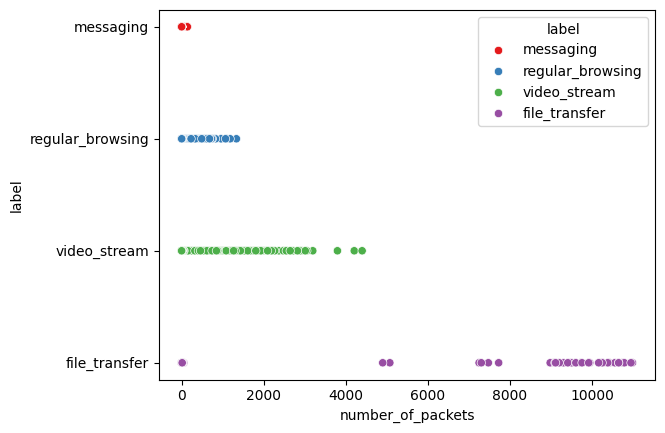

In [55]:
sns.scatterplot(
    x="number_of_packets",
    y="label",
    hue="label",  # Color by label
    palette="Set1",  # Adjust palette as desired
    data=df_adjusted
)

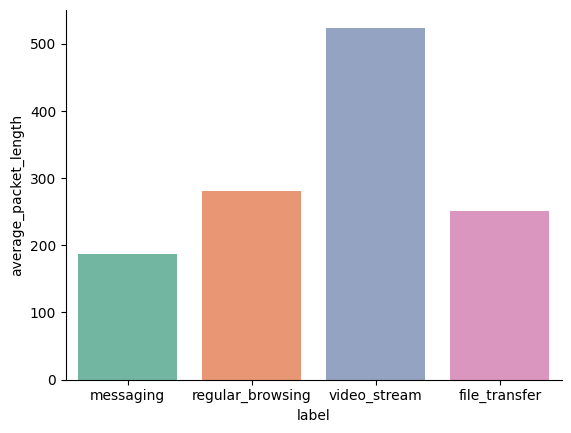

In [56]:
sns.barplot(
    x="label",
    y="average_packet_length",
    hue="label",  # Color by label
    palette="Set2",  # Adjust palette as desired
    data=df_adjusted,
    ci = None
)
sns.despine() 

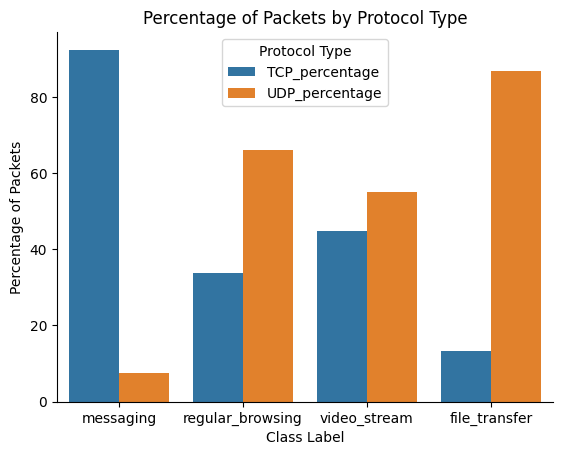

In [57]:
df_adjusted['TCP_percentage'] = df_adjusted['TCP_protocol_count'] / df_adjusted['number_of_packets'] * 100
df_adjusted['UDP_percentage'] = df_adjusted['UDP_protocol_count'] / df_adjusted['number_of_packets'] * 100

# Melt the DataFrame to have a single column for protocol type and another for percentage
df_melted = df_adjusted.melt(id_vars='label', value_vars=['TCP_percentage', 'UDP_percentage'], 
                              var_name='Protocol', value_name='Percentage')

# Plot the bar plot with hue for protocol type
sns.barplot(x="label", y="Percentage", hue="Protocol", data=df_melted, ci = None)

# Set labels and legend
plt.xlabel('Class Label')
plt.ylabel('Percentage of Packets')
plt.title('Percentage of Packets by Protocol Type')
plt.legend(title="Protocol Type")

# Remove the top and right spines
sns.despine()

plt.show()

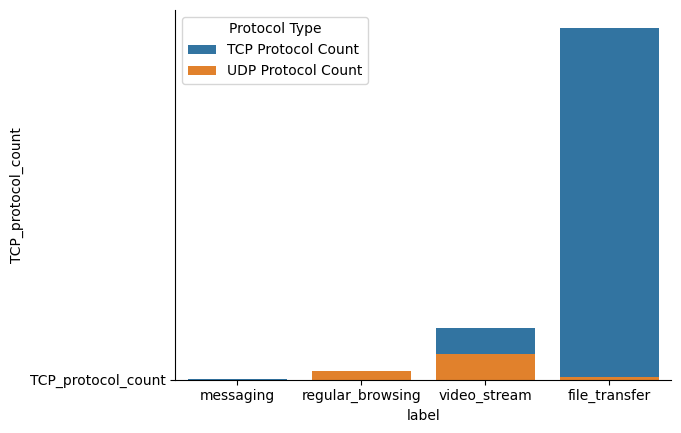

In [58]:
sns.barplot(
    x="label",
    y="TCP_protocol_count",
    label="TCP Protocol Count",
    data=df_adjusted,
    ci=None
)
sns.barplot(
    x="label",
    y="UDP_protocol_count",
    label="UDP Protocol Count",
    bottom="TCP_protocol_count",
    data=df_adjusted,
    ci=None
)
plt.legend(title="Protocol Type")
sns.despine()

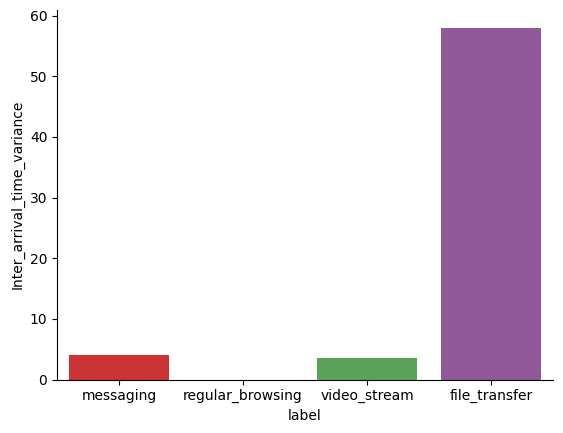

In [59]:
sns.barplot(
    x="label",
    y="Inter_arrival_time_variance",
    palette="Set1",
    data=df_adjusted,
    ci=None
)
sns.despine()

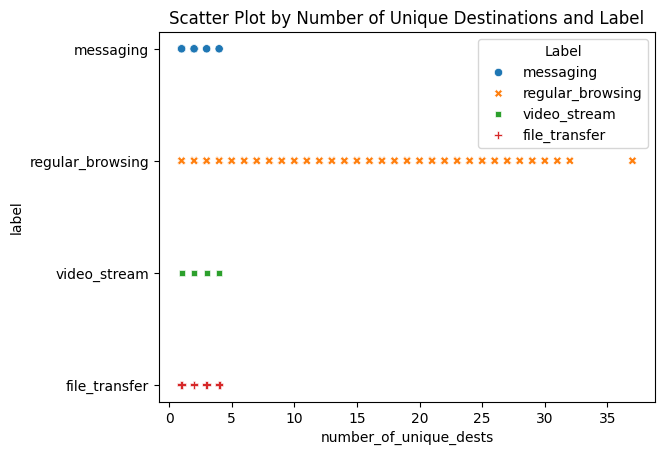

In [60]:
sns.scatterplot(data=df_adjusted, x="number_of_unique_dests", y="label", hue="label", style="label")

# Optional: Add a legend and a title for clarity
plt.legend(title='Label')
plt.title('Scatter Plot by Number of Unique Destinations and Label')
plt.show()

In [61]:
X = data.drop(['label'], axis=1)
y = data['label']

In [77]:
# Split the dataset into training+validation set and test set
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling and imputation
scaler = StandardScaler()
imputer = SimpleImputer(strategy='mean')

X_train_val_scaled = scaler.fit_transform(X_train_val)
X_train_val_scaled = imputer.fit_transform(X_train_val_scaled)
X_test_scaled = scaler.transform(X_test)
X_test_scaled = imputer.transform(X_test_scaled)

# Define the classifiers
clf1 = RandomForestClassifier(n_estimators=100, random_state=42)
clf2 = LogisticRegression(random_state=42, solver='liblinear', penalty='l1')
clf3 = KNeighborsClassifier(n_neighbors=5)
clf4 = SVC(probability=True, random_state=42)

In [78]:
eclf = VotingClassifier(
    estimators=[('rf', clf1), ('lr', clf2), ('knn', clf3), ('svm', clf4)],
    voting='soft'
)

In [79]:
eclf.fit(X_train_val_scaled, y_train_val)

VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                             ('lr',
                              LogisticRegression(penalty='l1', random_state=42,
                                                 solver='liblinear')),
                             ('knn', KNeighborsClassifier()),
                             ('svm', SVC(probability=True, random_state=42))],
                 voting='soft')

In [80]:
# Evaluate the model on the test set
y_test_pred = eclf.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.9079


In [66]:
def get_packet_details(pcap_file):
    packets=rdpcap(pcap_file)
    if 'netflix' in pcap_file or 'youtube' in pcap_file:
        label = 'video_stream'
    elif 'skype' in pcap_file:
        label = 'messaging'
    elif 'sftp' in pcap_file:
        label = 'file_transfer'
    elif 'regular_browsing' in pcap_file:
        label = 'regular_browsing'
    else:
        print(pcap_file)
        
    print(label,pcap_file, len(packets))

    packet_list = []
    
    for packet in packets:
        if IP in packet:
            packet_info = {
                'label': label,
                'timestamp': packet.time,
                'source_ip': packet[IP].src,
                'destination_ip': packet[IP].dst,
                'protocol': packet[IP].proto,
                'source_port': packet[IP].sport if TCP in packet or UDP in packet else None,
                'destination_port': packet[IP].dport if TCP in packet or UDP in packet else None,
                'packet_length': packet[IP].len,
                'label' : label
            }
            packet_list.append(packet_info)
    
    df = pd.DataFrame(packet_list)
    df = df.sort_values(by='timestamp')
    df['timestamp'] = df['timestamp'].astype(float)
    # Convert timestamps to a datetime format for easier manipulation
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    
    # Calculate time differences to find inter-arrival times
    df['time_diff'] = df['timestamp'].diff().dt.total_seconds().fillna(0)
    
    # Group by 0.25 second intervals. Assuming the first timestamp is the start.
    df['time_interval'] = (df['timestamp'] - df['timestamp'].min()).dt.total_seconds() // 0.25
    
    # Group by 'time_interval' and calculate the required attributes
    aggregated_data = df.groupby('time_interval').agg(
        number_of_packets=('timestamp', 'size'),
        average_packet_length=('packet_length', lambda x: round(x.mean(), 2)),
        number_of_unique_dests=('destination_ip', 'nunique'),
        TCP_protocol_count=('protocol', lambda x: (x==6).sum()),
        UDP_protocol_count=('protocol', lambda x: (x==17).sum()),
        #Inter_arrival_time_variance=('time_diff', np.var),
        #Packet_length_variance=('packet_length', np.var)
        #Inter_arrival_time_variance=('time_diff', lambda x: np.var(x, ddof=1)),
        #Packet_length_variance=('packet_length', lambda x: np.var(x, ddof=1))
        Packet_length_variance=('packet_length', lambda x: round(x.var() if len(x) > 1 else 0, 2)),
        Inter_arrival_time_variance=('time_diff', lambda x: round(x.var() if len(x) > 1 else 0, 2)),
        label = ('label','first')
    ).reset_index(drop=True)
    
    return aggregated_data
    

In [67]:
dataset_path = 'test_files'

test_df =  pd.DataFrame()

for filename in os.listdir(dataset_path):
    if 'pcap' in filename:
        pcap_file = os.path.join(dataset_path, filename)
        # print(pcap_file)
        print(pcap_file)
        packet_df = get_packet_details(pcap_file)
        test_df = pd.concat([test_df, packet_df], ignore_index=True)

test_files/nonvpn_netflix_capture1.pcap
video_stream test_files/nonvpn_netflix_capture1.pcap 240855
test_files/regular_browsing2.pcap
regular_browsing test_files/regular_browsing2.pcap 44036
test_files/nonvpn_skype-chat_capture11.pcap
messaging test_files/nonvpn_skype-chat_capture11.pcap 5859


In [81]:
test_df.head(5)

,number_of_packets,average_packet_length,number_of_unique_dests,TCP_protocol_count,UDP_protocol_count,Packet_length_variance,Inter_arrival_time_variance,label
0,29,180.52,4,27,2,41149.54,0.00,video_stream
1,6,75.50,2,6,0,739.50,0.00,video_stream
2,8,146.12,2,8,0,26146.12,0.02,video_stream
3,91,301.75,2,91,0,171900.17,0.03,video_stream
4,9,354.33,2,9,0,237196.75,0.00,video_stream


In [69]:
X = test_df.drop(['label'], axis=1)
y = test_df['label']

In [70]:
X_test_scaled = scaler.transform(X)
X_test_scaled = imputer.transform(X_test_scaled)

In [71]:
y_prediction = eclf.predict(X_test_scaled)

In [72]:
test_accuracy = accuracy_score(y, y_prediction)
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.9617
